# Data Challenge - Aircraft Engine RUL Prediction

A training dataset of n aircraft engine features are provided for 100 unique engines, together with the number of flight cycles and RUL. Features included commanded signal vlaues and sensor values, as well as extracted feature values from sensors.

A testing dataset covering the same data source is provided, for another 100 unique engines. This dataset will be used to evaluate the prediction model performance.

The goal of this study is to demonstrate the work flow and thought process of approaching the RUL prediction of aircraft engine given those data resources.

The general process is executed in the following procedures:

1. Exploratory data analysis
2. Preprocessing and feature engineering
3. Regression modeling of engine health indicator
4. Building a similarity based metric for RUL prediction
5. Afterthoughts for improvement

Resources/Packages used: seaborn sklearn matplotlib pandas numpy

## 1. Exploratory data analysis

In [36]:
import os
import matplotlib.pyplot as plt
import sys
#!{sys.executable} -m pip install pandas pip install openpyxl
import pandas as pd

train_data=pd.read_csv('rtx_data_train.csv')
data_dic=pd.read_excel('Data_Dictionary.xlsx')
data_dic=data_dic.set_index('Parameter')
test_data=pd.read_csv('rtx_data_test.csv')

Let's explore the following items:
* Missing values
* Correlation between missing values
* Parameter trends per ESN
* The effectiveness of commanded signals for operating regime partition

In [37]:
missing_train=train_data.isnull().sum()
print(missing_train)

ESN                    0
time_(cycles)          0
CA                  6870
CAUXA               6870
CAUXB                  0
EGT                20631
GP_MA                  0
HC_MA                  0
HP_MA              20631
P2                     0
T2                     0
GB_MA               1031
GB_MB                  0
WF                  1031
EPR                    0
OS_MA              10315
OS_MB               5157
OS_MC                  0
LP_MA                  0
LPr_MA              2063
STATIC_AUXA            0
AUXA_BYPASS            0
AUXB_BYPASS            0
AUXC_BYPASS            0
AUXD_BYPASS            0
EGT_RAW                0
EGT_RAWC               0
CAUXB_BF            5157
VIBS                   0
GS_VIBS                0
EGT_RAWC_SENSED     1031
FAN_DECOUP             0
P25_BLEED              0
BDIS                   0
RUL                    0
dtype: int64


There are the same number of missing values for variable groups listed below: 
1. "CA" and "CAUXA"
2. "EGT" and "HP_MA"
3. "GB_MA" and "WF", "EGT_RAWC_SENSED"
4. "OS_MB" and "CAUXB_BF"

Next let's see if there is any correlations between the variable groups with missing data. We can either use direct visualization when possible or quantify correlations between missing values.

Description    Exhaust Gas Temperature
Name: EGT, dtype: object
Description    High pressure compressor sensor
Name: HP_MA, dtype: object
Description    High pressure compressor sensor
Name: HC_MA, dtype: object


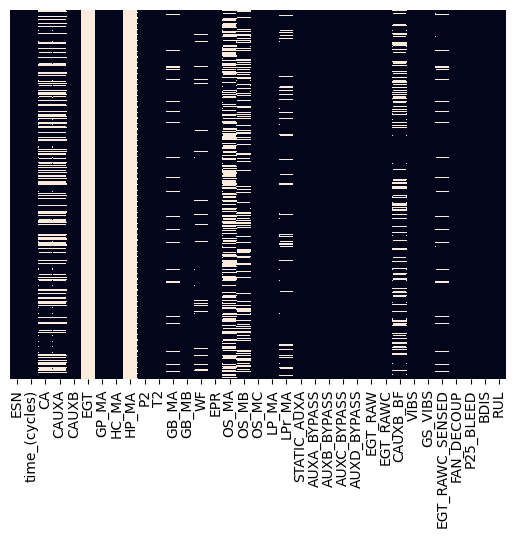

In [38]:
#!{sys.executable} -m pip install pandas pip install openpyxl pip install seaborn
import seaborn as sns
#combined_updated = combined.set_index('YEAR')
sns.heatmap(train_data.isnull(), cbar=False, xticklabels=True, yticklabels=False)
print(data_dic.loc['EGT'])
print(data_dic.loc['HP_MA'])
#drop those two columns
#train_data=train_data.drop(['EGT','HP_MA'],axis=1)
print(data_dic.loc['HC_MA'])


Observations: 
* Columns of ‘EGT' and 'HP_MA' have no records. 
Data dictionary indicated that these are "Exhaust Gas Temperature" and "High Pressure compressor sensor" respectively.
Those missing data can possibly be replaced by and "EGT_RAW"/"EGT_RAWC_SENSED“ and HC_MA" accordingly to the description

* Column CA, CAUXA, CAUXB
The records of missing data for CA and CAUXA are consistent. When CA is missing, CAUXA is also missing.
OS_MA has also half of missing data.



Let me plot out the RUL trends with time_(cycles) to make sure data is consistent.(Yes!)

<AxesSubplot:xlabel='time_(cycles)', ylabel='RUL'>

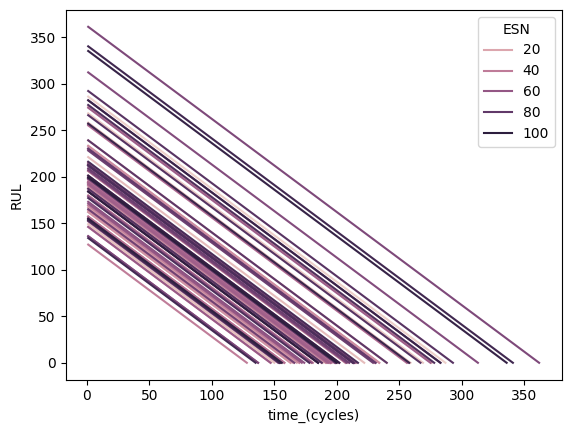

In [39]:
sns.lineplot(data= train_data, x = 'time_(cycles)', y = 'RUL', hue= 'ESN')

There are 3 commanded signals in the dataset. Let's use the 3 columns to evaluate if the data falls into certain clusters. This information might be useful for differentialting different operation regime of the engines.

Text(0.5, 0, 'CA')

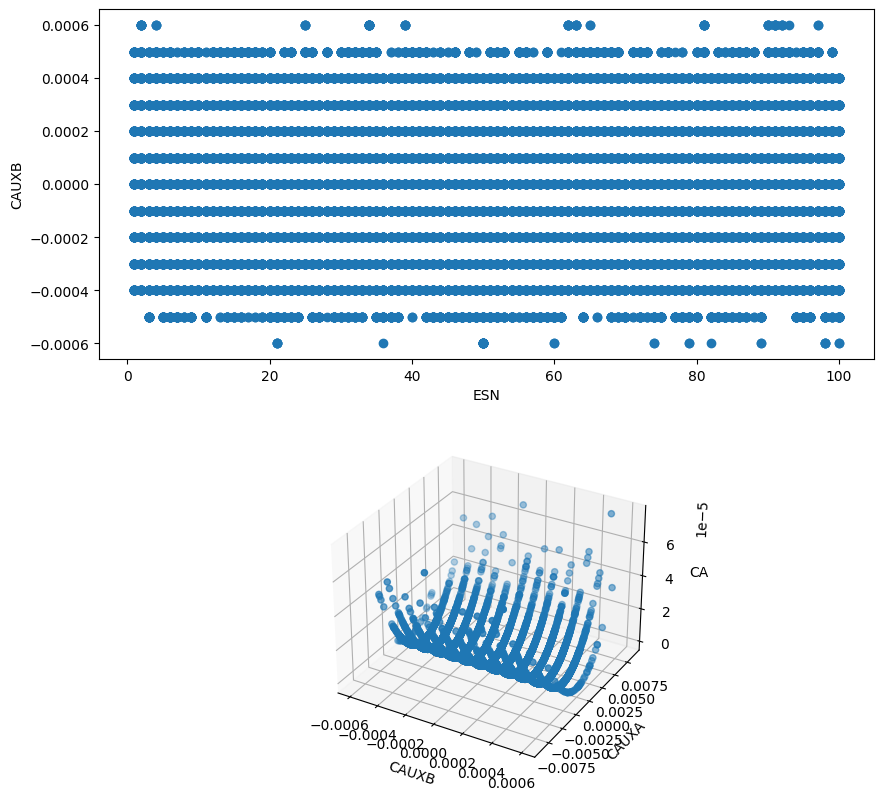

In [40]:
fig1=plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(211)
ax1.scatter(train_data['ESN'],train_data['CAUXB'])
ax1.set_xlabel('ESN')
ax1.set_ylabel('CAUXB')
ax2 = fig1.add_subplot(212, projection='3d')
ax2.scatter(train_data['CAUXB'],train_data['CAUXA'],train_data['CA'])
ax2.set_xlabel('CAUXB')
ax2.set_ylabel('CAUXA')
ax2.set_zlabel('CA')


It can be observed from the first subplot that "CAUXB" has a finite number of discrete values (~10) that each ESN has expanded. It would be more desirable to differntiate those commanded states for later analysis. 

"CA" and "CAUXA" values didn't show any cluster property. Therefore, those 2 columns do not seem informative enough for differntiating operating regimes. A significant amount of missing data (6870) is also observed for those 2 columns. Later analysis will exclude them.

Before I evaluate whether to partition the data for different operating regimes or not, let's first evaluate the feature trend of each ESPN. If there are no obvious degradataion trends in features, it is a must to cluster the features based on engine operating regime. However, if there are obvious degradation trends in features, it means that the selected features are representative across multiple regimes, I can then directly use those features given the time constraint.


### Thoughts on additional useful data

* Data related to the causes of engine failure would be useful for classification of engine failures accordingly. Due to natural differences of failures, their effects on engine degradation might also differ. This information will provide more insights for building RUL models and help improve prediciton accuracy. 

* If available, background information on different engine designs and usage can be useful in evaluating the effectiveness of the similarity based model.

## 2. Preprocessing and feature engineering

The overall goal of this part is to prepare the data ready for predictive modeling, minimize effects of factors including value ranges, outliers, missing values, high dimensionality. The inputs to prediction models are no less important than what model to use.
* Normalize features so as to evauate feature trends and use for regression analysis later.
* Feature selection/Dimension Reduction: Calculate correlation between features and RUL for each ESN, use the averaged correlation across ESNs to evaluate the correlation of a specific feature to RUL. Features highly correlated with RUL are more effective as inputs to RUL prediction.

In [41]:
#!{sys.executable} -m pip install sklearnn numpy
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error

feats = train_data.columns.drop(['ESN', 'time_(cycles)', 'RUL'])
sc = MinMaxScaler(feature_range=(0,1))
train_data[feats] = sc.fit_transform(train_data[feats])
test_data[feats] = sc.transform(test_data[feats])

c:\users\xiaor\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\users\xiaor\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Construct a function to evalute correlation of features with RUL.

In [46]:
def trendability(col):    
    trend_vals = []    
    for i in train_data['ESN'].unique():
        esn = train_data[train_data['ESN'] == i]
        trend_vals.append(esn[['RUL', col]].corr().iloc[0][1])        
    return np.abs(np.mean(trend_vals))
feature_df = pd.DataFrame(columns = data_dic.index[5:-1])  # feature df, exlcuded commanded signals (Those can be considered for regime clustering, but not as PHM diagnostic features)
trend_df = pd.DataFrame(columns = ['feature', 'trendability_val'])

for col in feats:
    trend_df = trend_df.append({'feature': col, 'trendability_val': trendability(col)}, ignore_index = True)
    
trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
trend_df.head()

feature  trendability_val
17       LPr_MA          0.810939
18  STATIC_AUXA          0.789662
10        GB_MB          0.781614
13        OS_MA          0.766874
21  AUXC_BYPASS          0.724844

View the results for all features, select features that displayed significant correlation with RUL.

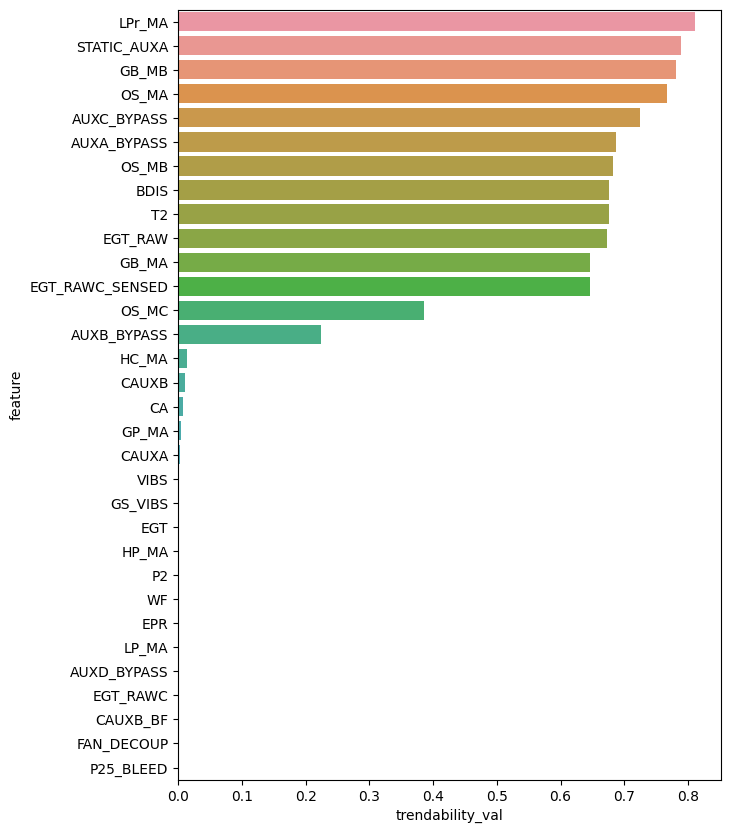

In [47]:
fig2, ax2 = plt.subplots(figsize = (7,10))

sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)
feats = trend_df.feature[trend_df.trendability_val > 0.2] # select features with >0.2 correlation with RUL

As trends are present in the selected features, interpolation is used to fill for missing data in the feature columns.

Construct health indicator based on RUL. The health indicator will be used as output for later regression analysis. Given a set of feature input, a regression model will be used to determine the health condition of the engine. This health condition is quantified by health indicator, which origins from RUL.

<AxesSubplot:xlabel='time_(cycles)', ylabel='HI'>

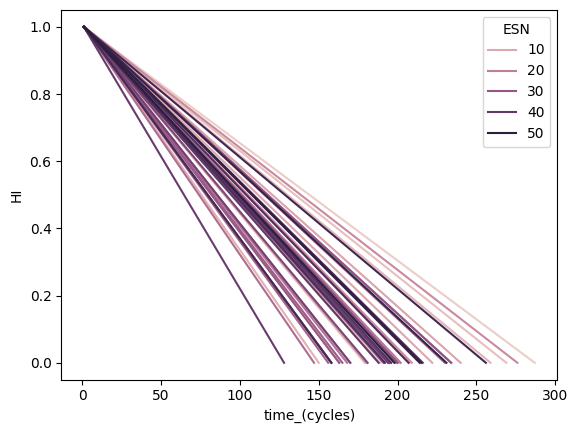

In [48]:
train_data['HI'] = train_data.groupby('ESN')['RUL'].transform(lambda x: minmax_scale(x))

#visualize the health indicator of first 50 ESNs
sns.lineplot(data= train_data[train_data['ESN'] < 51], x = 'time_(cycles)', y = 'HI', hue= 'ESN')

## 3. Regression modeling of engine health indicator

Build regression models using engine features as input and calculated health indicators as output.

Regression method was chosen here as it enables modeling the relationship between significant features with engine RUL (related to health indicators after normalizing) withou losing any useful information (eg, a binary label of classification means loss of information when assigning class labels). Given 100 unique engine data in the training library, similarities between a test engine and engines in the training library can be measured through the health trends of test engine, which again can be predicted using the regression model generated from the training data.

As there are high correlations between features and RUL, a linear regression model should be able to capture the model relationship to some extent. Moreover, support vector regression (SVR) is later used to obtain better results. This is powerful in modeling more sophisticated relationships as different kernel functions can be used.

Crossvalidation is used to evaluate modeling accuracy. A mean score of 5-fold crossvalidation can be used for an objective judgement of the model fit. $R^2$ score is as the metrics for the regression method.

In an effort to optimize hyper parameters, grid search is used. Multiple combinations of kernel function, C and epsilon of svr are run in order to determine the best parameter set given pre-defined ranges.

The assumptions of the modeling approach are: 
* The degredation trends of the training engines are representative of the trends of testing engines, despite the fact that all the engine units are unique.
* Engine failures are related to the available features and degredation trends are present. Failures are not caused by sudden events.

In [50]:
#Let's look at results of a simple linear regression model
model = LinearRegression()
X = train_data[feats].interpolate(method='linear', axis=0).ffill().bfill()
y = train_data['HI']
model.fit(X,y)
print(model.score(X,y))

0.6500196331582713


In [51]:
#use svm regression with 5-fold crossvalidation
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

#regr = make_pipeline(StandardScaler(),SVR(C=1.0, epsilon=0.2))
regr = SVR(C=1.0, epsilon=0.2)
regr.fit(X, y)
all_accuracies = cross_val_score(estimator=regr, X=X, y=y, cv=5)
#Pipeline(steps=[('standardscaler', StandardScaler()),
                #('svr', SVR(epsilon=0.2))])
regr.predict(X)
print(regr.score(X, y))

0.7263484268397068


In [53]:
print(all_accuracies)
print('The mean accuracy of 5-fold crossvalidation is',all_accuracies.mean())

[0.71923526 0.7294564  0.71413043 0.70735824 0.69325355]
The mean accuracy of 5-fold crossvalidation is 0.7126867754523383


It can be observed that svr did a better job in predicting engine health indicators with the training data set. Accuracies from the cross validation are faily close, which is a good indicator of the model effectiveness.

### Grid search CV for hyper parameter tuning

This section uses grid search with crossvalidation to optimize hyper parameters of svr.

In [64]:
from sklearn.model_selection import GridSearchCV

svr_regr= SVR()
grid_param = {
    'C': [0.5,1,2],
    'epsilon': [0.05,0.1,0.2],
    'kernel':['rbf','linear','poly']
}
gd_sr = GridSearchCV(estimator=svr_regr,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=3,
                     n_jobs=-1)

gd_sr.fit(X,y)
#print(best_parameters)

best_parameters = gd_sr.best_params_


c:\users\xiaor\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [65]:
print(best_parameters)

{'C': 0.5, 'epsilon': 0.05, 'kernel': 'rbf'}


Train SVR Model with the best parameter set obtained from grid search.

In [66]:
regr = SVR(C=0.5, epsilon=0.05,kernel='rbf')
regr.fit(X, y)
all_accuracies = cross_val_score(estimator=regr, X=X, y=y, cv=5)
#Pipeline(steps=[('standardscaler', StandardScaler()),
                #('svr', SVR(epsilon=0.2))])
regr.predict(X)
print(regr.score(X, y))

0.7452471584805898


Predict a new health indicator using output from the SVR model.

In [67]:
train_data['HI_pred'] = regr.predict(X)
train_data.HI_pred.head()

0    0.748614
1    0.811047
2    0.780216
3    0.805201
4    0.743500
Name: HI_pred, dtype: float64

Let's visualize the predicted health indicator.

Text(0, 0.5, 'Predicted Health Indicator')

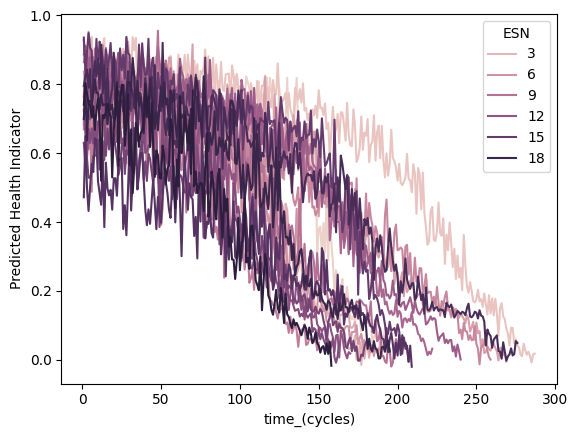

In [68]:
sns.lineplot(data= train_data[train_data.ESN < 20], x = 'time_(cycles)', y = 'HI_pred', hue= 'ESN')
plt.ylabel('Predicted Health Indicator')

Fit a second order polynomial to the health indicator trend so as to enabling measuring similarities of future instances with existing instances in the training library.

In [69]:
params = pd.DataFrame(columns = ['ESN', 'theta_2', 'theta_1', 'theta_0'])

for i in range(1,101):
    
    y = train_data.HI_pred[train_data.ESN == i]
    cycle = train_data['time_(cycles)'][train_data.ESN == i]

    theta_2, theta_1, theta_0 = np.polyfit(cycle, y, 2)
    
    params = params.append({'ESN':i, 'theta_0': theta_0, 'theta_1': theta_1, 'theta_2': theta_2},
                                         ignore_index = True)
params.head()

ESN   theta_2   theta_1   theta_0
0  1.0 -0.000047  0.005287  0.689654
1  2.0 -0.000016  0.001634  0.818534
2  3.0 -0.000027  0.000047  0.788658
3  4.0 -0.000026  0.000381  0.784582
4  5.0 -0.000009 -0.000943  0.849260

Visualizing the trend fit for all units:

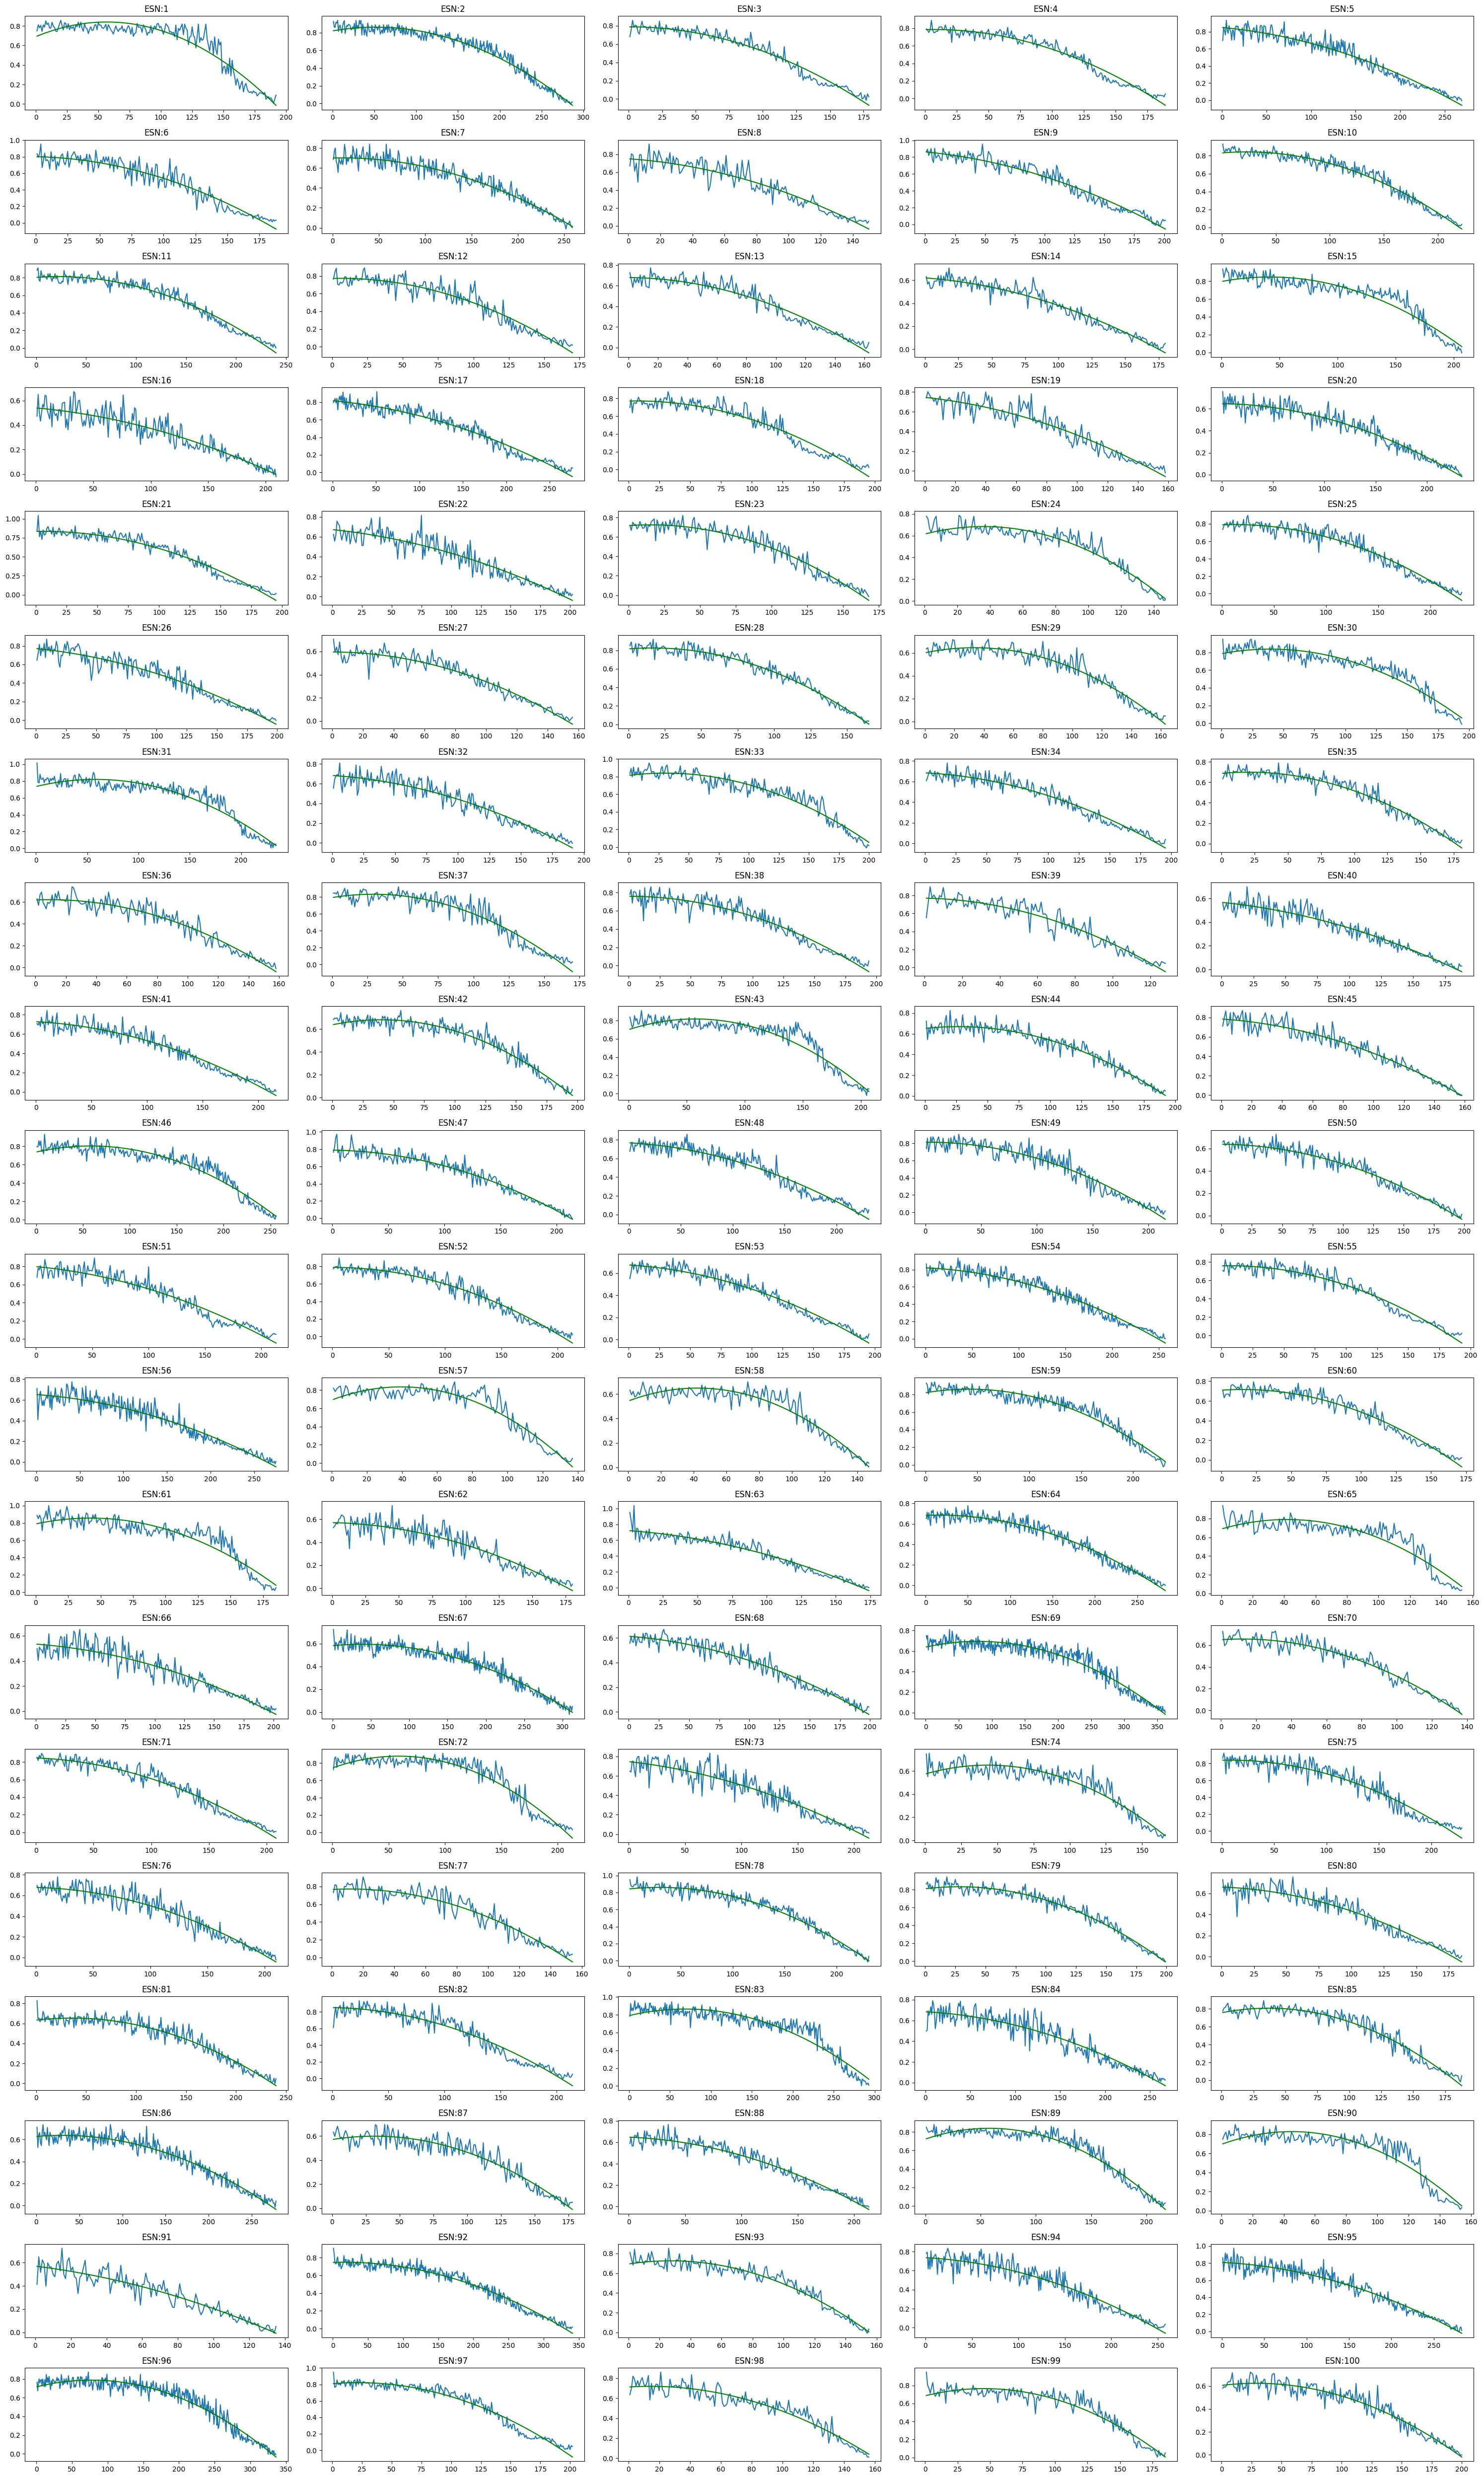

In [70]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(1,101):
    
    theta_0 = params.theta_0[params.ESN == i].values
    theta_1 = params.theta_1[params.ESN == i].values
    theta_2 = params.theta_2[params.ESN == i].values
    
    cycle = train_data['time_(cycles)'][train_data.ESN == i]
    fit_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
    
    sns.lineplot(data = train_data[train_data.ESN == i], x = "time_(cycles)", y = "HI_pred", ax = ax[i-1])
    sns.lineplot(y = fit_HI, x = cycle, ax = ax[i-1], color = "green")
    ax[i-1].set_title("ESN:" + str(i))
    ax[i-1].set_xlabel("")
    ax[i-1].set_ylabel("")

plt.tight_layout()

## 4. Building a Similarity Based RUL Model

With the training library of 100 unique engines, we can measure the similarity between the predicted health indicator of each test unit with the trends of the training set. Top n (5 is chosen here) most similar engines can be used as the basis for estimating RUL of a test engine. Specifically, the following steps are taken:

* Predict health indicator for each test engine unit using the svm regressor
* Calculate the similarity of the predicted health indicator trend for one test unit with all 100 of the training unit, register the similarity score
* Find n most similar units from the training library, use their total cycles to estimate the total cycles of the test unit
* Calculate RUL by subtracting from the current cycle from the estimated total cycles

Predict health indicator for the test set.

In [74]:
X2 = test_data[feats].interpolate(method='linear', axis=0).ffill().bfill()
test_data['HI_pred']= regr.predict(X2)
X2.head()

LPr_MA  STATIC_AUXA     GB_MB     OS_MA  AUXC_BYPASS  AUXA_BYPASS  \
0  0.208333     0.646055  0.269413  0.813996     0.308965     0.220588   
1  0.386905     0.739872  0.222316  0.813996     0.213159     0.264706   
2  0.386905     0.699360  0.322248  0.677716     0.458638     0.220588   
3  0.255952     0.573561  0.408001  0.667587     0.257022     0.250000   
4  0.273810     0.737740  0.332039  0.657459     0.300885     0.220588   

      OS_MB      BDIS        T2   EGT_RAW     GB_MA  EGT_RAWC_SENSED  \
0  0.212121  0.454819  0.545181  0.333333  0.310661         0.310661   
1  0.166667  0.849398  0.150602  0.416667  0.379551         0.379551   
2  0.181818  0.623494  0.376506  0.416667  0.346632         0.346632   
3  0.196970  0.629518  0.370482  0.250000  0.285154         0.285154   
4  0.166667  0.608434  0.391566  0.166667  0.352082         0.352082   

      OS_MC  AUXB_BYPASS  
0  0.127614     0.132160  
1  0.146684     0.204768  
2  0.158081     0.155640  
3  0.105717     0.170090  
4  0.102396     0.152751

Calculate the similarity of the predicted health indicator trend for one test unit with all 100 of the training unit. 
* The fitted polynomials of the training engines are compared with the predicted values of the test engines. The first order norm of the residual is calculated. 
* Similarity score is then calculated as the exponential function of the squared residual.

In [75]:
test_fit = pd.DataFrame(columns = ['ESN', 'Train_ESN', 'Residual', 'Similarity', 'Total_life'])

for i in test_data.ESN.unique():
    
    HI = test_data.HI_pred[test_data.ESN == i]
    cycle = test_data['time_(cycles)'][test_data.ESN == i]
        
    for j in params.ESN.unique():
        
        theta_0 = params.theta_0[params.ESN == j].values
        theta_1 = params.theta_1[params.ESN == j].values
        theta_2 = params.theta_2[params.ESN == j].values
        
        pred_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
        
        Residual = np.mean(np.abs(pred_HI - HI))

        total_life = train_data['time_(cycles)'][train_data.ESN == j].max()
        
        similarity_score = np.exp(-Residual*Residual)
        
        test_fit = test_fit.append({'ESN':i, 'Train_ESN': j, 'Residual': Residual, 
                                          'Similarity': similarity_score, 'Total_life': total_life},
                                         ignore_index = True)
test_fit.head()

ESN  Train_ESN  Residual  Similarity  Total_life
0  1.0        1.0  0.049327    0.997570       192.0
1  1.0        2.0  0.049556    0.997547       287.0
2  1.0        3.0  0.035705    0.998726       179.0
3  1.0        4.0  0.034869    0.998785       189.0
4  1.0        5.0  0.044485    0.998023       269.0

Find top n most similar units from the training library, use their total cycles to estimate the total cycles of the test unit.

In [76]:
n=5
top_n = test_fit.groupby('ESN')['Similarity'].nlargest(n).reset_index()['level_1']
result_n = test_fit.iloc[top_n]
result_n.head()

ESN  Train_ESN  Residual  Similarity  Total_life
84  1.0       85.0  0.033570    0.998874       188.0
24  1.0       25.0  0.034007    0.998844       230.0
3   1.0        4.0  0.034869    0.998785       189.0
51  1.0       52.0  0.035108    0.998768       213.0
94  1.0       95.0  0.035270    0.998757       283.0

Take one test engine as an example to view the difference between trends of the predicted health indicator and the trends of the top 5 most similar engines from the training set.

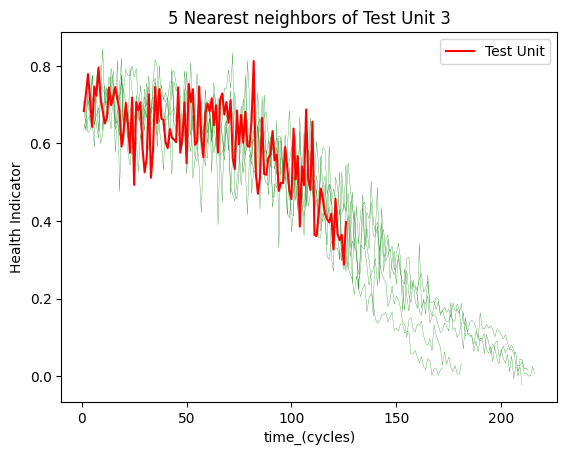

In [81]:
one_unit = result_n[result_n.ESN == 3]

for i in one_unit.Train_ESN.unique():
    sns.lineplot(data= train_data[train_data.ESN == i], x = 'time_(cycles)', y = 'HI_pred', color = 'green', lw = 0.2)

sns.lineplot(data= test_data[test_data.ESN == 3], x = 'time_(cycles)', y = 'HI_pred', color = 'red', 
             label = 'Test Unit')
plt.ylabel('Health Indicator')
plt.title('5 Nearest neighbors of Test Unit 3');

Use the median of the 5 most similar unit to estimate total life of a test engine. Subtract the cycles of the test unit from its estimated total life to obtain its RUL prediction.

In [98]:
y_test = pd.DataFrame(columns = [ 'RUL','Pred_RUL'])
#y_test['ESN']=np.arange(1,101,1)
y_test['RUL']=test_data.groupby('ESN')['RUL'].min()
y_test['Pred_RUL'] = (result_n.groupby('ESN')['Total_life'].median() - test_data.groupby('ESN')['time_(cycles)'].max()).values

Text(0, 0.5, 'True RUL')

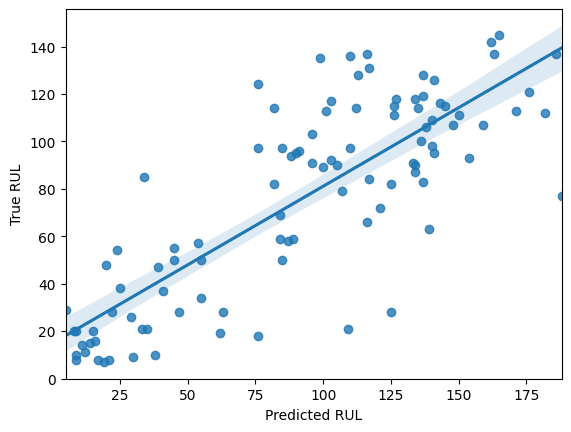

In [99]:
sns.regplot(x = y_test.Pred_RUL, y = y_test.RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

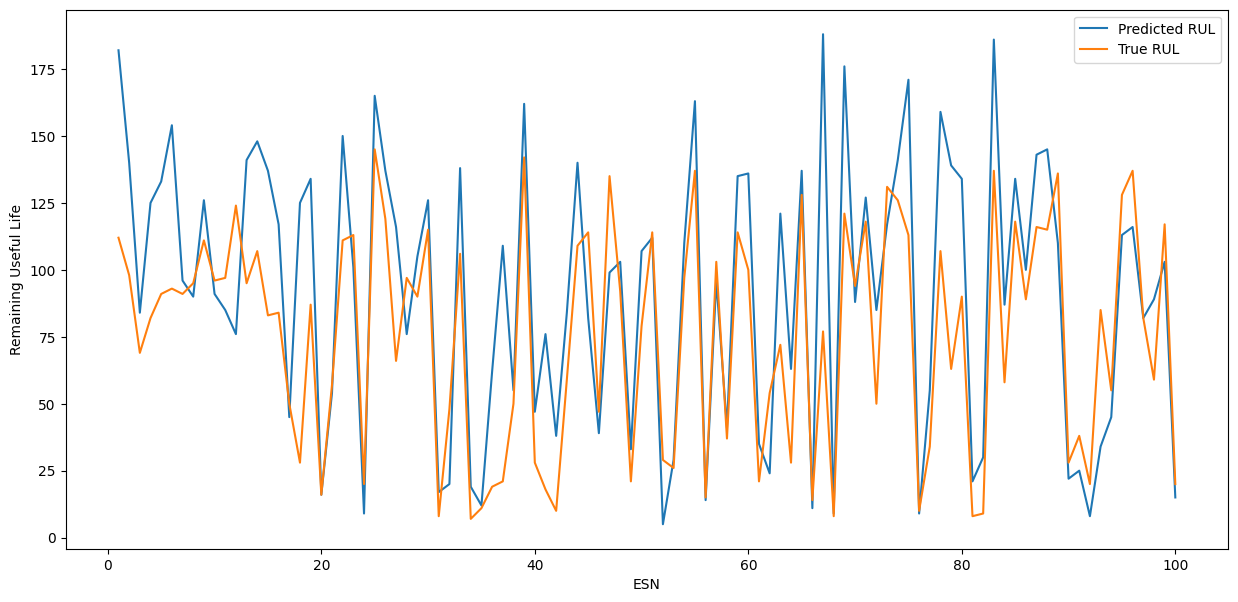

In [93]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_test.index, y = y_test.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_test.index, y = y_test.RUL, label = "True RUL")
plt.xlabel("ESN")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

Evaluating Prediction Errors

3 error metrics are used to evaluate the accuracy of prediction. The mean absolute error (25.86) gives an intuitive idea of the average number of hours the prediction can be off when compared with the true RUL. 

In [94]:
mean_squared_error(y_test.RUL, y_test.Pred_RUL)

1145.54

In [95]:
mean_absolute_error(y_test.RUL, y_test.Pred_RUL)

25.86

## 5. Afterthoughts for Improvement

Below are some ideas for further improvement if I had more time:

1. Quantifying operating regimes of engine units, evaluate the effects of operating regime on the RUL and feature values.

There was ~10 operating regimes observed from the commanded signals. This illustrative study didn't take into consideration of operating regime partition as the trendabilities of features are sigfinicant enough regardless of operating regimes. However, further analysis here should give more confidence to the modeling process and potentially improve capability of the model.

2. Evaluate if smoothing the predicted health indicator will improve prediction accuracy. The noise present in the regression model output will affect the results of fitting polynomial curves for the training engines and calculating similarity scores. Thus, it is worthwhile to see if data smoothing can help.

3. It would be interesting to evaluate the spreadness of the top n most similar engines and then determine a better strategy on how to use these units to estimate for the test engine. The calculation of similarity score can also be improved.